In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using CUDA, BenchmarkTools
CUDA.allowscalar(false)

  Activating project at `~/cscs2023`


In [2]:
# work around a Jupyter bug
HTML("""
    <style>
        /*Disable code output line wrapping*/
        div.jp-RenderedText pre {
            white-space: pre;
        }
    </style>""")

HTML{String}("<style>\n    /*Disable code output line wrapping*/\n    div.jp-RenderedText pre {\n        white-space: pre;\n    }\n</style>")

# Kernel analysis and optimization

Once your application has been optimized, it's time to look at individual kernels. Initially, BenchmarkTools.jl and NSight Systems still are good tools to estimate the execution time of a kernel. For more insights, you can use the CUDA APIs, or use NSight Compute to dive deeply into a kernel's execution properties.

Optimizing algorithms and kernels for GPU execution is a very broad subject, impossible to cover in-depth during a single session like this.

Common optimizations include:

- algorithmic optimizations: using parallel algorithms instead of serial ones
- reducing global memory accesses: caching, or using fine-grained mechanisms to communicate between threads
- reducing register usage, to increase occupancy
- avoiding thread divergence: each thread in a warp should essentially execute the same instructions
- optimizing memory accesses: avoiding bank conflicts, making accesses coalescable

Instead of covering each of these, I'll focus on some demonstrating the tools that could help you, as well as cover some Julia-specific optimizations. For general kernel optimization guidelines, refer to the NVIDIA documentation or other on-line resources.

## Case study: RMSE

Let's go back to the RMSE kernel we developed in the previous notebook:

In [3]:
function rmse(A::AbstractArray{T}, B::AbstractArray{T}) where T
    @assert size(A) == size(B)
    C = similar(A, 1)
    C .= 0

    function rmse_kernel(C, A, B)
        i = (blockIdx().x-1) * blockDim().x + threadIdx().x
        stride = gridDim().x * blockDim().x

        # grid-stride loop
        while i <= length(A)
            a = A[i]
            b = B[i]
            CUDA.@atomic C[] += (a-b)^2

            i += stride
        end
    end

    let kernel = @cuda launch=false rmse_kernel(C, A, B)
        config = CUDA.launch_configuration(kernel.fun)
        threads = min(length(A), config.threads)
        blocks = cld(length(A), threads)
        blocks = min(blocks, config.blocks)

        kernel(C, A, B; threads, blocks)
    end

    return CUDA.@allowscalar sqrt(C[] / length(A))
end

rmse (generic function with 1 method)

<div class="alert alert-block alert-info">
    <strong>Note</strong>: Instead of separate host and device functions, both are contained in a single function here. This is generally a good idea, as it allows to make assumptions inside the kernel that only hold if it was launched in a specific way.
</div>

In [4]:
A = CUDA.rand(2048, 2048)
B = CUDA.rand(2048, 2048)

@benchmark rmse(A, B)

BenchmarkTools.Trial: 503 samples with 1 evaluation.
 Range (min … max):  9.915 ms … 10.021 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.935 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.936 ms ±  7.295 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                          ▃▆██▇▇▆▅▅▄▃                         
  ▄▁██▇▇▄▆▆▁▄▁▁▁▁▁▁▆▁▁▆▁█▇███████████▇▇▇▆▄▁▇▁▇▄▄▄▁▆▄▆▇▁▇▆▆▁▄ █
  9.91 ms      Histogram: log(frequency) by time     9.96 ms <

 Memory estimate: 2.02 KiB, allocs estimate: 37.

Remember that this implementation performed badly compared to using array operations:

In [5]:
function rmse_baseline(A, B)
    bc = Base.broadcasted(A, B) do a, b
        (a - b) ^ 2
    end
    bc = Broadcast.instantiate(bc)
    sqrt(sum(bc) / length(A))
end

@benchmark rmse_baseline(A, B)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  174.030 μs …  47.308 ms  ┊ GC (min … max): 0.00% … 25.96%
 Time  (median):     176.608 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   182.122 μs ± 471.356 μs  ┊ GC (mean ± σ):  0.67% ±  0.26%

       ▃▆█▇▄▁                                                    
  ▁▁▂▃▇██████▆▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  174 μs           Histogram: frequency by time          192 μs <

 Memory estimate: 4.66 KiB, allocs estimate: 84.

<div class="alert alert-block alert-info">
    <strong>Note</strong>: The baseline performance is twice that of what we reported in the previous notebook, because we're `CUDA.rand` defaults to single-precision floating point numbers. This effect would be even larger (up to 64x!) when using consumer hardware.
</div>

It's not useful to use NSight Systems here, as we're only launching a single kernel and the GPU is fully utilized:

In [7]:
CUDA.@profile rmse(A, B)

Profiler ran for 11.0 ms, capturing 541 events.

Host-side activity: calling CUDA APIs took 10.37 ms (94.24% of the trace)
┌──────────┬────────────┬───────┬─────────────────────────────────────┬─────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                   │ Name                    │
├──────────┼────────────┼───────┼─────────────────────────────────────┼─────────────────────────┤
│   94.26% │   10.37 ms │     2 │   5.19 ms ± 7.33   (   0.0 ‥ 10.37) │ cuStreamSynchronize     │
│    0.33% │   35.76 µs │     2 │  17.88 µs ± 13.49  (  8.34 ‥ 27.42) │ cuLaunchKernel          │
│    0.23% │   25.27 µs │     1 │                                     │ cuMemcpyDtoHAsync       │
│    0.19% │    20.5 µs │     1 │                                     │ cuMemAllocFromPoolAsync │
└──────────┴────────────┴───────┴─────────────────────────────────────┴─────────────────────────┘

Device-side activity: GPU was busy for 10.81 ms (98.30% of the trace)
┌──────────┬──────────

The tool to use now is NSight Compute, which allows us to profile individual kernels.

## NSight Compute

Where NSight Systems is used for profiling a GPU application, NSight Compute is used to profile individual kernels. Similarly to NSight Compute, you can use it to profile an entire application, or to connect to a running application.

<div class="alert alert-block alert-info">
    <b>Note</b>: When profiling with NSight Compute, the UI needs to connect to the target machine. To connect to our compute node, we'd need to set up SSH, which is somewhat involved on this cluster (requiring MFA and an SSH key generator). Not to lose too much time on this, I'll be showing screenshots for the remainder of this notebook.
</div>

After connecting the NSight Compute UI to an application launched under `ncu --mode=launch`, you'll be presented with the following view that's halted at the first API call:

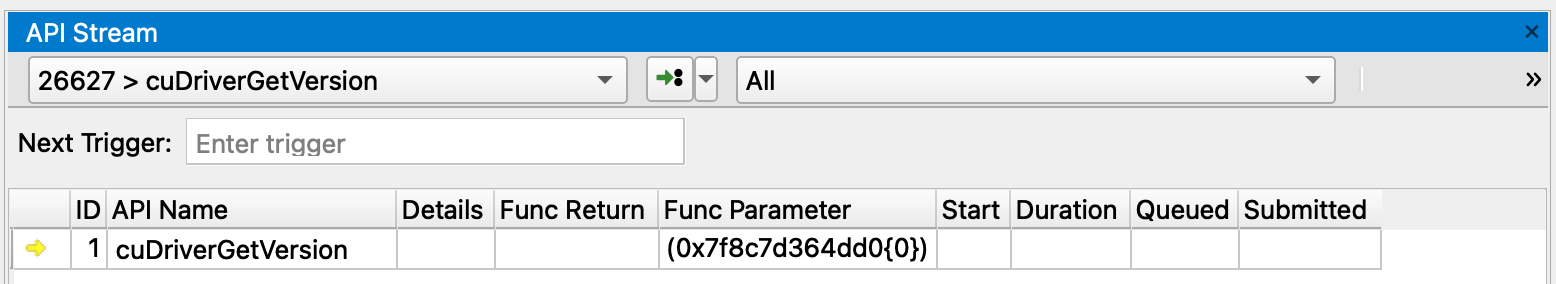

Then, enable "Profile" > "Auto Profile", disable "Debug" > "Break on API Error", and resume execution by pressing F5.

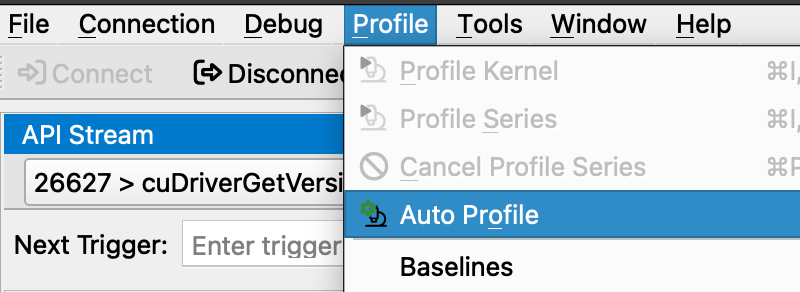

We can now execute any kernel, and observe its characteristics in NSight Compute. For example:

In [8]:
CuArray([1]) .+ 1

1-element CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}:
 2

On the "Summary" page, we can see some high-level information about this kernel:

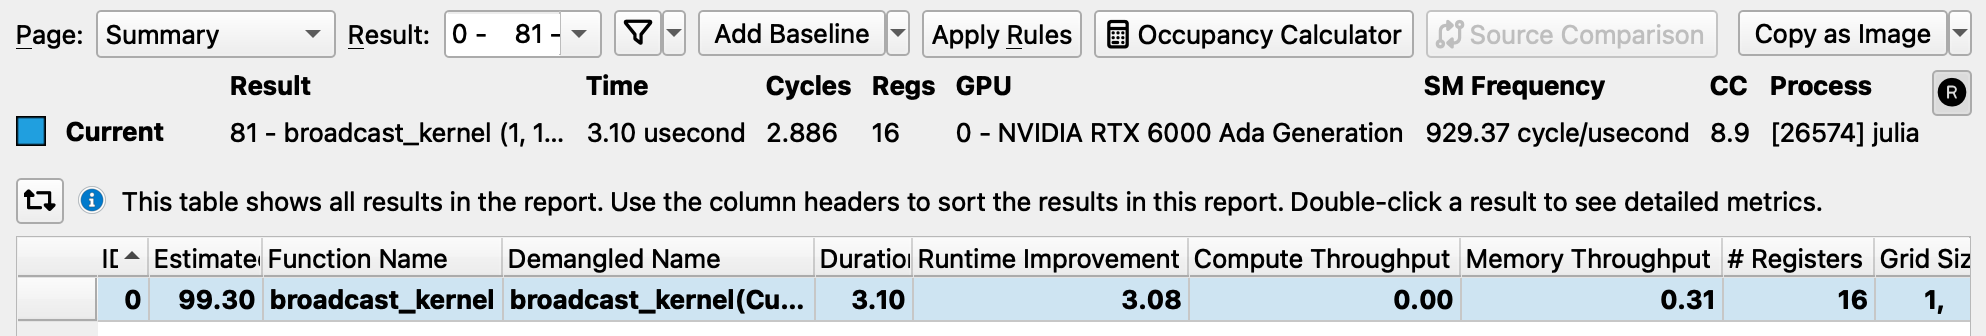

Let's apply this tool to our RMSE kernel implementation.

## Case study: RMSE

In [9]:
rmse(A, B)

0.40711522f0

The summary page immediately gives us two important aspects to look at:

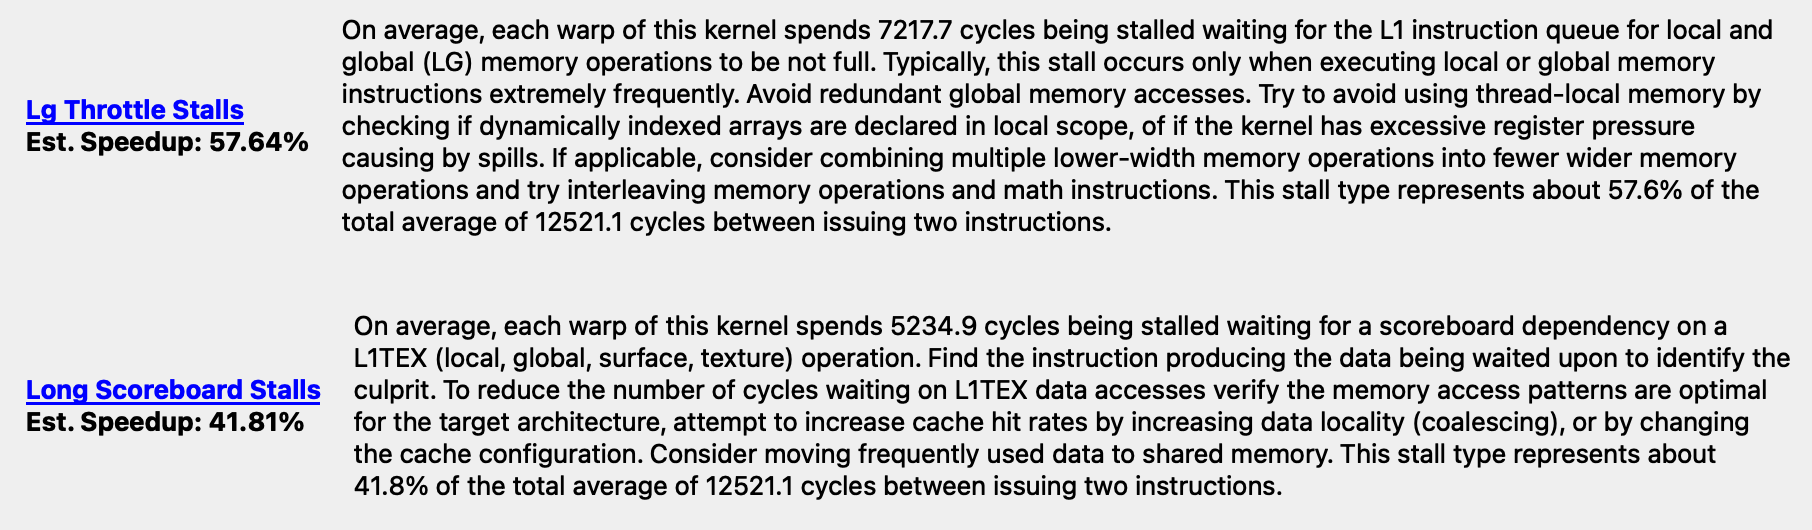

So it looks like our kernel is stalled on global memory operations. This is a common occurrence, and global memory operations are generally something we need to avoid as much as possible, instead using more local memories like shared memory, or using warp-level communication.

In the "Source" page, we can look at the Julia, PTX and SASS code for our kernel, next to performance metrics for each line of code. Since we're suffering from stalls, let's inspect those:

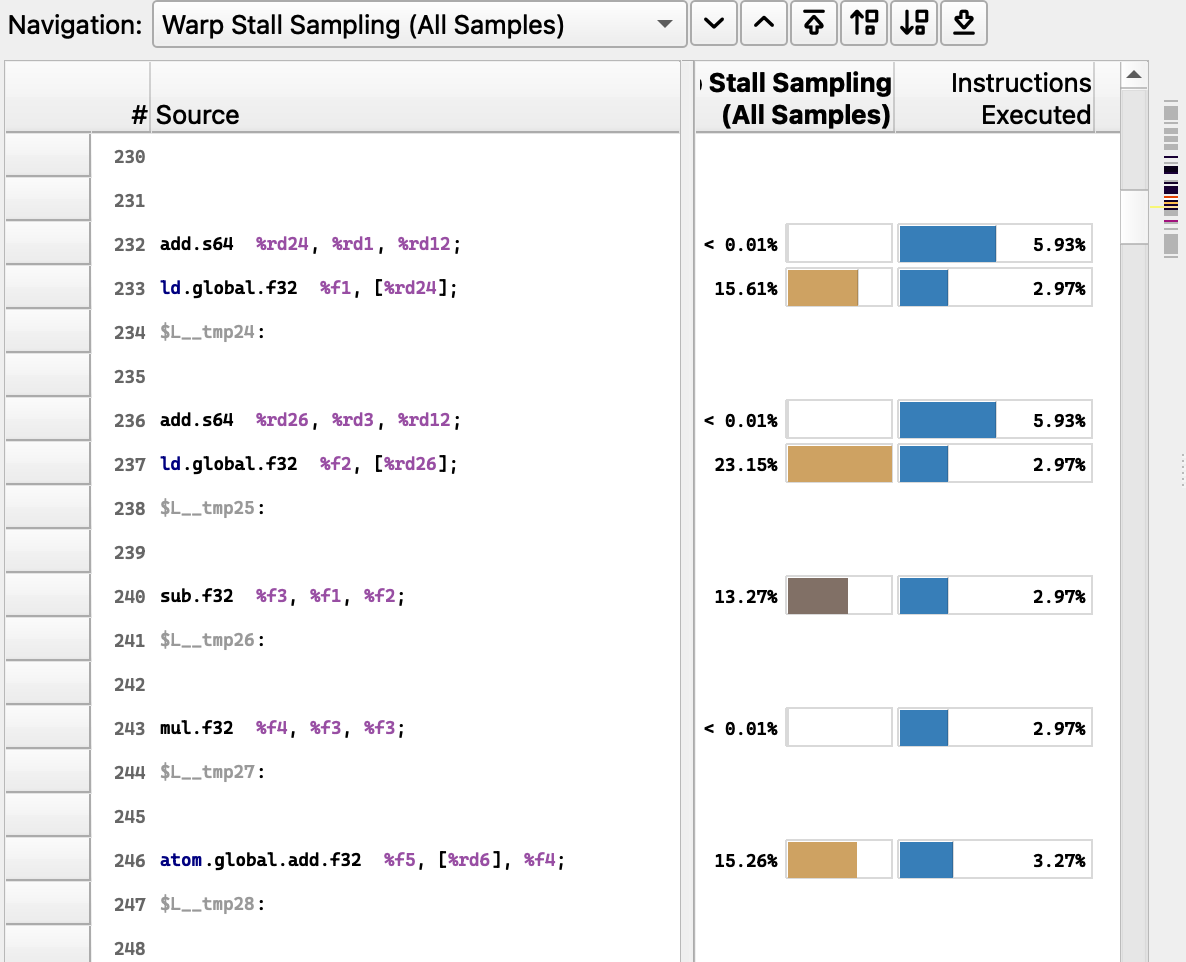

<div class="alert alert-block alert-info">
    <strong>Note</strong>: Debug info is a work in progress, so the PTX or SASS to source code mapping is currently incomplete.
</div>

The global memory loads here correspond to our grid stride loop:

```julia
# grid-stride loop
while i <= length(A)
    a = A[i]
    b = B[i]
    CUDA.@atomic C[] += (a-b)^2

    i += stride
end
```

We cannot avoid the loads, but the atomic store is another story:

- we can avoid storing at every iteration, instead doing so after the loop
- we can avoid storing by every thread, instead aggregating the result of multiple threads

Let's start with the first optimization.

In [9]:
function rmse(A::AbstractArray{T}, B::AbstractArray{T}) where T
    @assert size(A) == size(B)
    C = similar(A, 1)
    C .= 0

    function rmse_kernel(C, A, B)
        i = (blockIdx().x-1) * blockDim().x + threadIdx().x
        stride = gridDim().x * blockDim().x

        # grid-stride loop
        val = zero(T)
        while i <= length(A)
            a = A[i]
            b = B[i]
            val += (a-b)^2                 # <-- changed

            i += stride
        end
        CUDA.@atomic C[] += val            # <-- changed
        return
    end

    let kernel = @cuda launch=false rmse_kernel(C, A, B)
        config = CUDA.launch_configuration(kernel.fun)
        threads = min(length(A), config.threads)
        blocks = cld(length(A), threads)
        blocks = min(blocks, config.blocks)

        kernel(C, A, B; threads, blocks)
    end

    return CUDA.@allowscalar sqrt(C[] / length(A))
end

rmse (generic function with 1 method)

Let's benchmark this optimization. Note that, if running under NSight Compute, you first need to disable "Auto Profile" before invoking `@benchmark` or _every_ single benchmark iteration will be analyzed.

In [11]:
@benchmark rmse(A, B)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  357.767 μs … 708.458 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     363.486 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   376.056 μs ±  21.043 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   █▆ ▇▄                                                         
  ▄█████▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▆▄▃▄▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  358 μs           Histogram: frequency by time          426 μs <

 Memory estimate: 2.00 KiB, allocs estimate: 36.

A 30x improvement! Let's look at NSight Compute again, to confirm our findings:

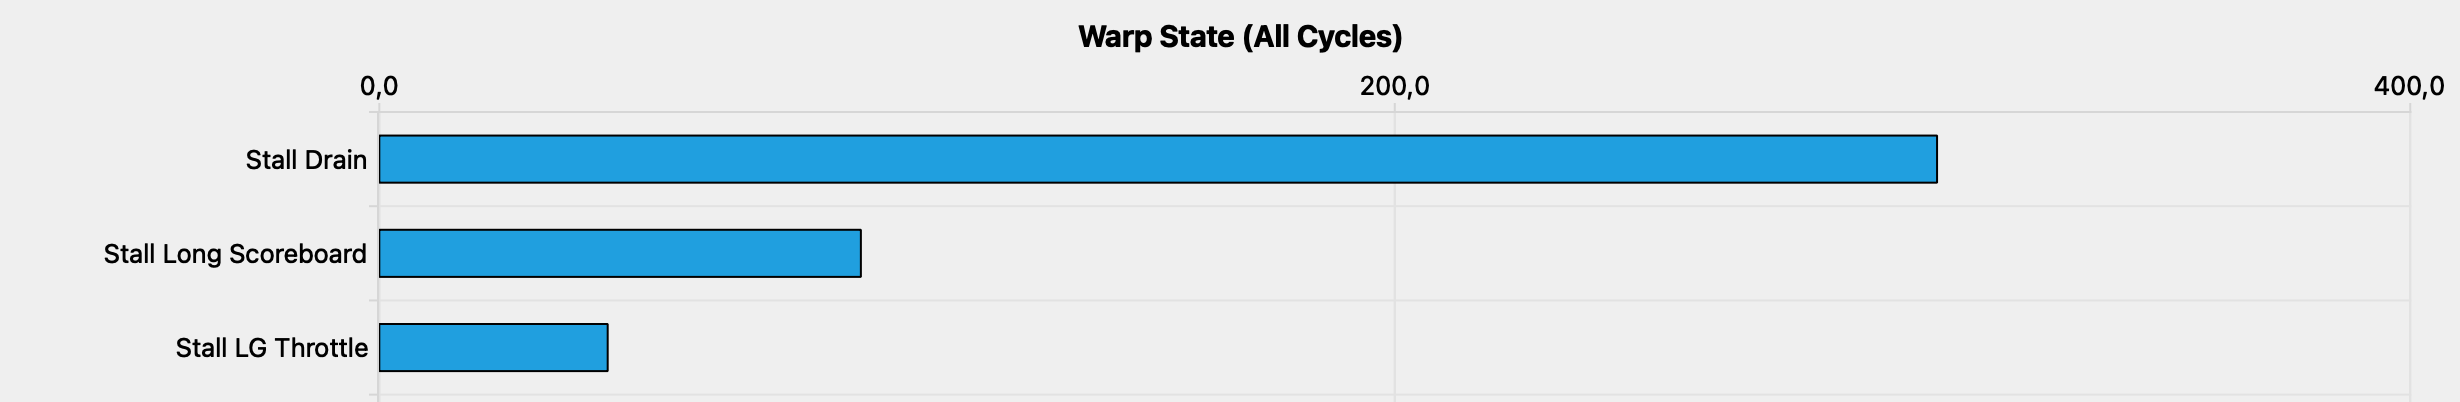

Notice how we're still mostly suffering from stalls, despite performance being OK now. This illustrates how memory stalls aren't bad per se as long as there's enough work to hide them (one of the core principles of GPU execution is that the device can cheaply switch between threads).

The NVIDIA Kernel Profiling guide mentions that drain stalls come from memory stores that happen near the end of a kernel, which coincides with the remaining `@atomic` store into `C`. So let's further avoid that store by aggregating the result of multiple threads.

## Parallel reduction

Let's look at the core of our kernel again:

```julia
val = zero(T)
while i <= length(A)
    a = A[i]
    b = B[i]
    val += (a-b)^2

    i += stride
end
CUDA.@atomic C[] += val
```

Here, every kernel is accessing global memory. That's not optimal, since we could first use a more local memory resource to aggregate partial results. This is a very common topic in GPU programming, so much so that there's many resources on implementing parallel reductions in CUDA.

For example, we could first use shared memory to aggregate partial results within a block, and only have a single thread per block write the result to global memory:

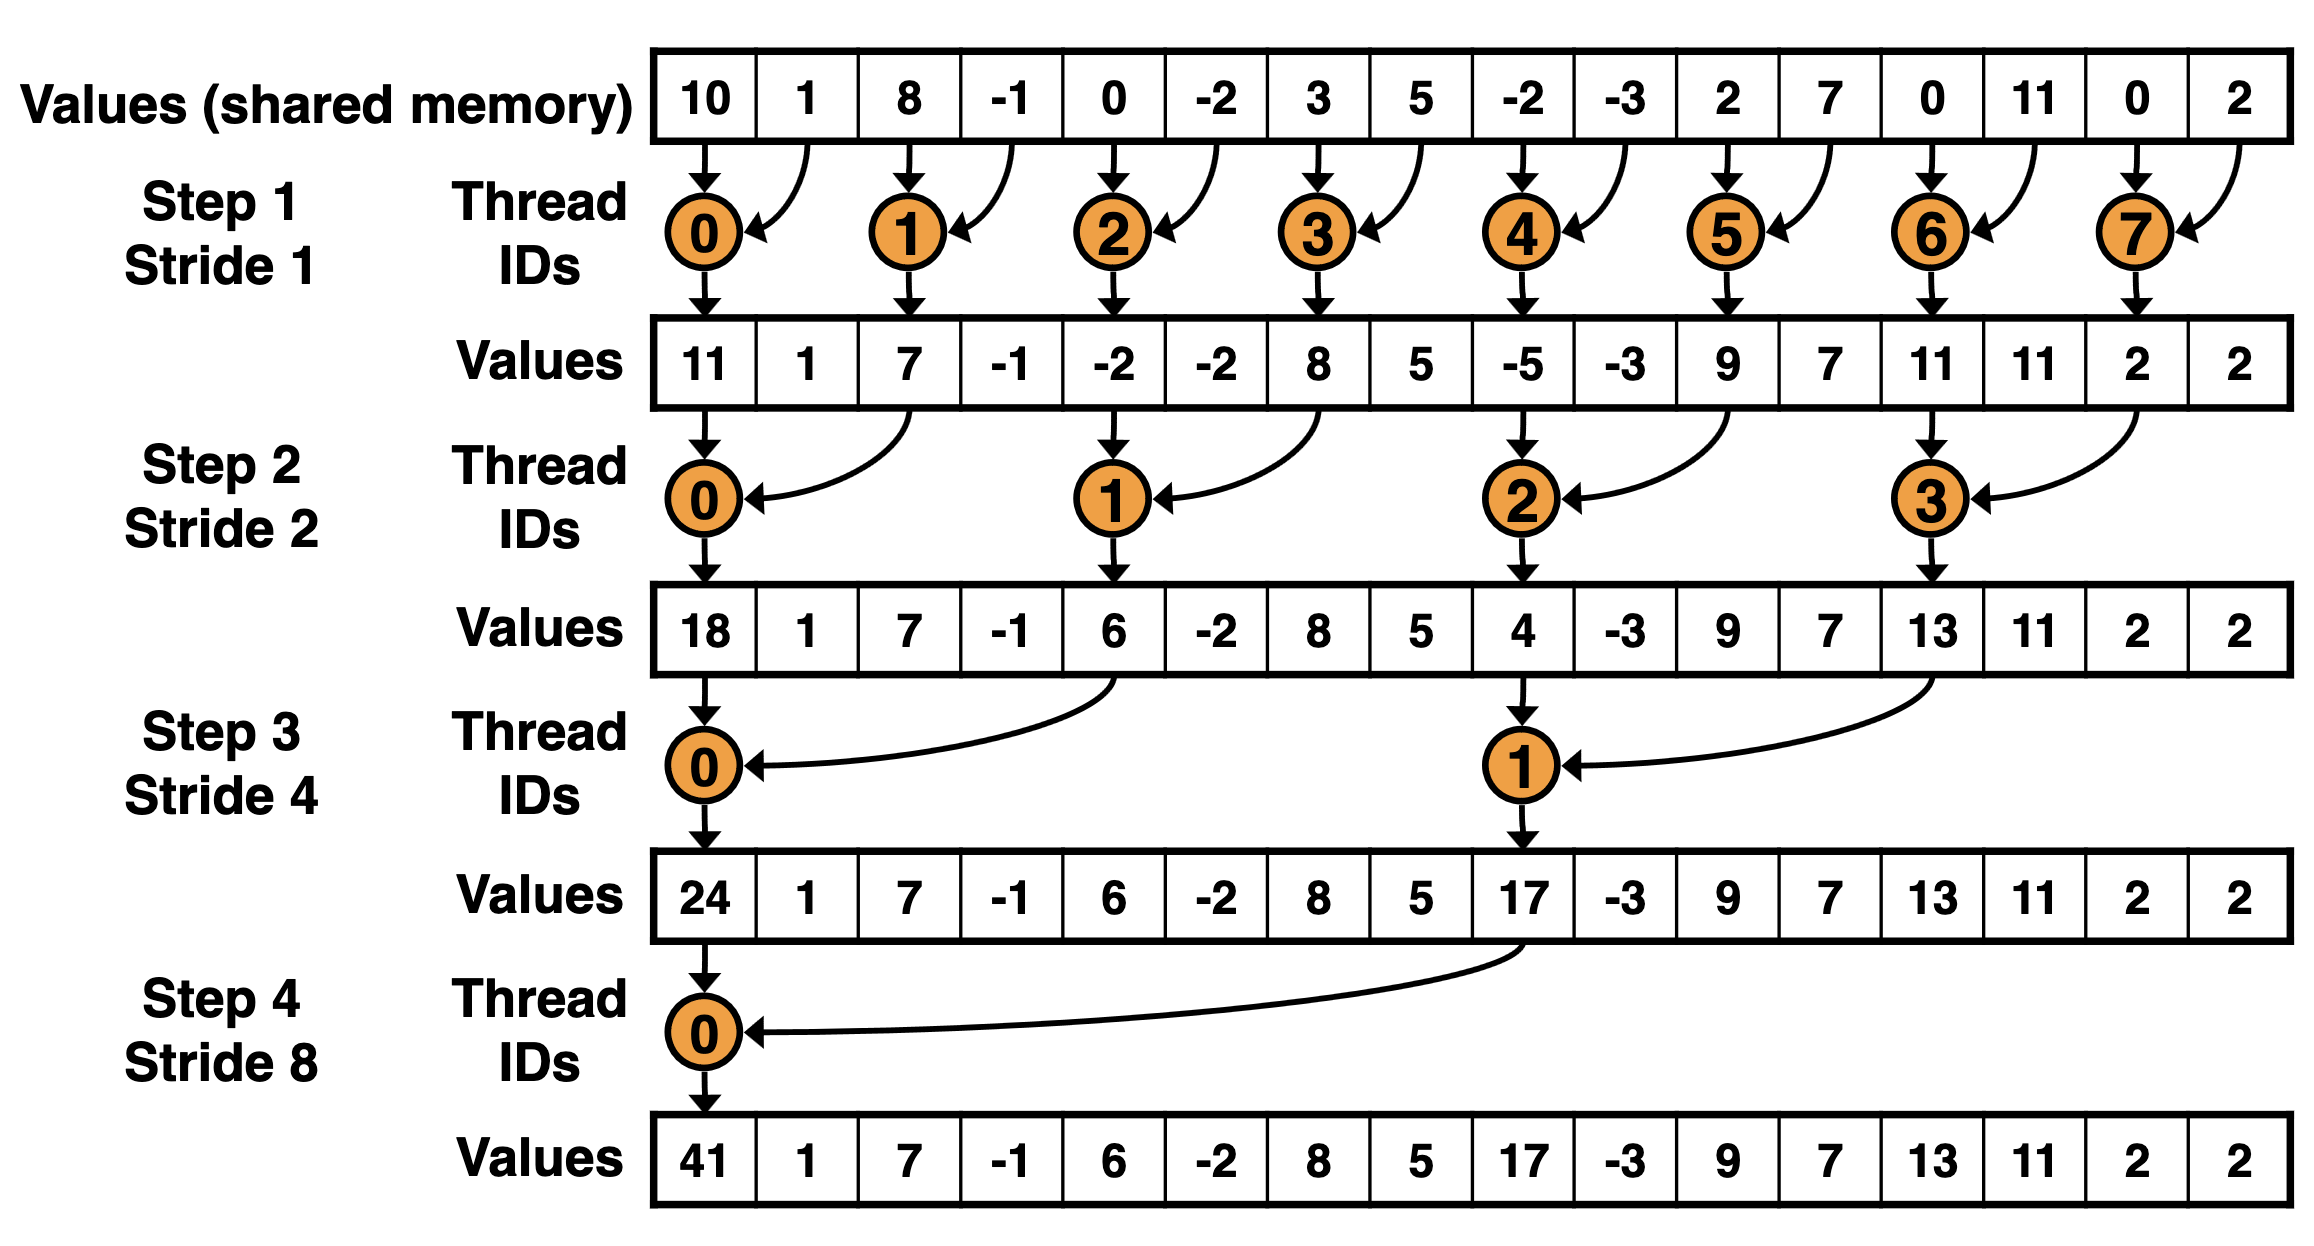

Try to implement this for the simplified case where we're using a power-of-two block size. For example, use a loop that starts with `stride = 1` and doubles it until it exceeds the block dimension. One way to determine whether a thread still participates, is by checking if the thread number is divisible by the next stride (i.e., `mod(thread, next_stride) == 0`, or `mod1(thread, next_stride)` using Julia's 1-based indices).

In [12]:
function rmse(A::AbstractArray{T}, B::AbstractArray{T}) where T
    @assert size(A) == size(B)
    C = similar(A, 1)
    C .= 0

    function rmse_kernel(C, A, B)
        i = (blockIdx().x-1) * blockDim().x + threadIdx().x
        stride = gridDim().x * blockDim().x

        # grid-stride loop to process elements on a single thread
        val = zero(T)
        while i <= length(A)
            a = A[i]
            b = B[i]
            val += (a-b)^2

            i += stride
        end

        # initialize shared memory
        thread = threadIdx().x
        threads = blockDim().x
        shared = CuDynamicSharedArray(eltype(C), (threads,))
        shared[thread] = val
        sync_threads()

        # perform a parallel reduction
        stride = 1
        while stride < blockDim().x
            if mod1(thread, 2*stride) == 1
                shared[thread] += shared[thread+s]
            end
            sync_threads()
            stride *= 2
        end

        # load the final value on the first thread
        if thread == 1
            val = shared[thread]
            CUDA.@atomic C[] += val
        end

        return
    end

    @cuda threads=256 shmem=256*sizeof(T) rmse_kernel(C, A, B)
    # because of the grid stride loop, the launch configuration doesn matter :-)

    return CUDA.@allowscalar sqrt(C[] / length(A))
end

rmse (generic function with 1 method)

Generalizing this to non-pow2 inputs is always a bit tricky, so let's copy a more advanced version from NVIDIA's guide on [optimizing parallel reduction in CUDA](https://developer.download.nvidia.com/assets/cuda/files/reduction.pdf) (that also performs better by optimizing memory access order):

In [13]:
function rmse(A::AbstractArray{T}, B::AbstractArray{T}) where T
    @assert size(A) == size(B)
    C = similar(A, 1)
    C .= 0

    function rmse_kernel(C, A, B)
        i = (blockIdx().x-1) * blockDim().x + threadIdx().x
        stride = gridDim().x * blockDim().x

        # grid-stride loop to process elements on a single thread
        val = zero(T)
        while i <= length(A)
            a = A[i]
            b = B[i]
            val += (a-b)^2

            i += stride
        end

        # initialize shared memory
        thread = threadIdx().x
        threads = blockDim().x
        shared = CuDynamicSharedArray(eltype(C), (threads,))
        shared[thread] = val

        # perform a parallel reduction
        d = 1
        while d < threads
            sync_threads()
            index = 2 * d * (thread-1) + 1
            if index <= threads
                other_val = if index + d <= threads
                    shared[index+d]
                else
                    zero(eltype(C))
                end
                shared[index] = shared[index] + other_val
            end
            d *= 2
        end

        # load the final value on the first thread
        if thread == 1
            val = shared[thread]
            CUDA.@atomic C[] += val
        end

        return
    end

    let kernel = @cuda launch=false rmse_kernel(C, A, B)
        # we need to inform the occupancy API about the shared memory usage!
        shmem(threads) = threads * sizeof(T)

        config = CUDA.launch_configuration(kernel.fun; shmem)
        threads = min(length(A), config.threads)
        blocks = cld(length(A), threads)
        blocks = min(blocks, config.blocks)

        kernel(C, A, B; threads, blocks, shmem=shmem(threads))
    end

    return CUDA.@allowscalar sqrt(C[] / length(A))
end

rmse (generic function with 1 method)

In [14]:
@benchmark rmse(A, B)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  103.798 μs … 453.741 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     105.917 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   106.626 μs ±   4.644 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▁▆█▇▄                                                      
  ▂▃▄▅██████▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  104 μs           Histogram: frequency by time          121 μs <

 Memory estimate: 2.14 KiB, allocs estimate: 39.

Another 3x improvement, and we're now outperforming our implementation using array operations!
We could take this even further by using warp-level communication, but let's move on to other things.

## Code reflection

Another powerful tool to optimize kernels, is by looking at the generated code:

- `@device_code_warntype`: typed Julia code, for spotting type instabilities
- `@device_code_llvm`: LLVM IR, still very readable
- `@device_code_ptx`: PTX ISA, pretty verbose, for verifying use of specific instructions
- `@device_code_sass`: for the brave; mostly undocumented, GPU-specific assembly

These macros can be put in front of any host code, and will generate output for every called kernel:

In [20]:
@device_code_warntype CuArray([1]) .+ 1

PTX CompilerJob of MethodInstance for (::GPUArrays.var"#broadcast_kernel#38")(::CUDA.CuKernelContext, ::CuDeviceVector{Int64, 1}, ::Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{1}, Tuple{Base.OneTo{Int64}}, typeof(+), Tuple{Base.Broadcast.Extruded{CuDeviceVector{Int64, 1}, Tuple{Bool}, Tuple{Int64}}, Int64}}, ::Int64) for sm_60

MethodInstance for (::GPUArrays.var"#broadcast_kernel#38")(::CUDA.CuKernelContext, ::CuDeviceVector{Int64, 1}, ::Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{1}, Tuple{Base.OneTo{Int64}}, typeof(+), Tuple{Base.Broadcast.Extruded{CuDeviceVector{Int64, 1}, Tuple{Bool}, Tuple{Int64}}, Int64}}, ::Int64)
  from (::GPUArrays.var"#broadcast_kernel#38")(ctx, dest, bc′, nelem) @ GPUArrays /scratch/snx3000/julia/tbesard/daint-gpu/packages/GPUArrays/dAUOE/src/host/broadcast.jl:59
Arguments
  #self#::Core.Const(GPUArrays.var"#broadcast_kernel#38"())
  ctx::Core.Const(CUDA.CuKernelContext())
  dest::CuDeviceVector{Int64, 1}
  bc′::Base.Broadcast.Broadcasted{CUDA.CuArrayStyl

In [16]:
@device_code_llvm @cuda identity(nothing)

; PTX CompilerJob of MethodInstance for identity(::Nothing) for sm_60
;  @ operators.jl:522 within `identity`
define ptx_kernel void @_Z8identityv({ i64, i32 } %state) local_unnamed_addr {
conversion:
  ret void
}


In [17]:
@device_code_ptx @cuda identity(nothing)

// PTX CompilerJob of MethodInstance for identity(::Nothing) for sm_60

//
// Generated by LLVM NVPTX Back-End
//

.version 7.4
.target sm_60
.address_size 64

	// .globl	_Z8identityv            // -- Begin function _Z8identityv
                                        // @_Z8identityv
.visible .entry _Z8identityv(
	.param .align 8 .b8 _Z8identityv_param_0[16]
)
{


// %bb.0:                               // %conversion
	ret;
                                        // -- End function
}


In [4]:
@device_code_sass @cuda identity(nothing)

// PTX CompilerJob of MethodInstance for identity(::Nothing) for sm_86

	.headerflags	@"EF_CUDA_TEXMODE_UNIFIED EF_CUDA_64BIT_ADDRESS EF_CUDA_SM89 EF_CUDA_VIRTUAL_SM(EF_CUDA_SM86)"
	.elftype	@"ET_EXEC"


//--------------------- .text._Z8identityv        --------------------------
	.section	.text._Z8identityv,"ax",@progbits
	.sectioninfo	@"SHI_REGISTERS=4"
	.align	128
        .global         _Z8identityv
        .type           _Z8identityv,@function
        .size           _Z8identityv,(.L_x_1 - _Z8identityv)
        .other          _Z8identityv,@"STO_CUDA_ENTRY STV_DEFAULT"
_Z8identityv:

.text._Z8identityv:
; Location ./operators.jl:522
        MOV R1, c[0x0][0x28] ;
        EXIT ;

.L_x_0:
        BRA `(.L_x_0);
        NOP;
        NOP;
        NOP;
        NOP;
        NOP;
        NOP;
        NOP;
        NOP;
        NOP;
        NOP;
        NOP;
        NOP;
        NOP;

.L_x_1:


## Kernel introspection

Although NSight Systems and NSight Compute can be used to gather information about kernels, you can also use the CUDA APIs. In fact, we've been doing that all along by using the occupancy APIs:

In [21]:
kernel = @cuda launch=false identity(nothing)

CUDA.HostKernel for identity(Nothing)

In [22]:
CUDA.launch_configuration(kernel.fun)

(blocks = 112, threads = 1024)

This suggested launch configuration is based on the amount of registers and memory used by the kernel, which we can also query directly:

In [23]:
CUDA.registers(kernel)

2

In [24]:
CUDA.memory(kernel)

(local = 0, shared = 0, constant = 0)

## Reducing register usage

Minimizing the register usage of kernels is important, because it allows the GPU to keep more warps in flight (i.e. it increases occupancy), which is important for its ability to hide memory latency. In fact, NSight Compute provides a roofline plot that shows the relationship between register usage and occupancy:

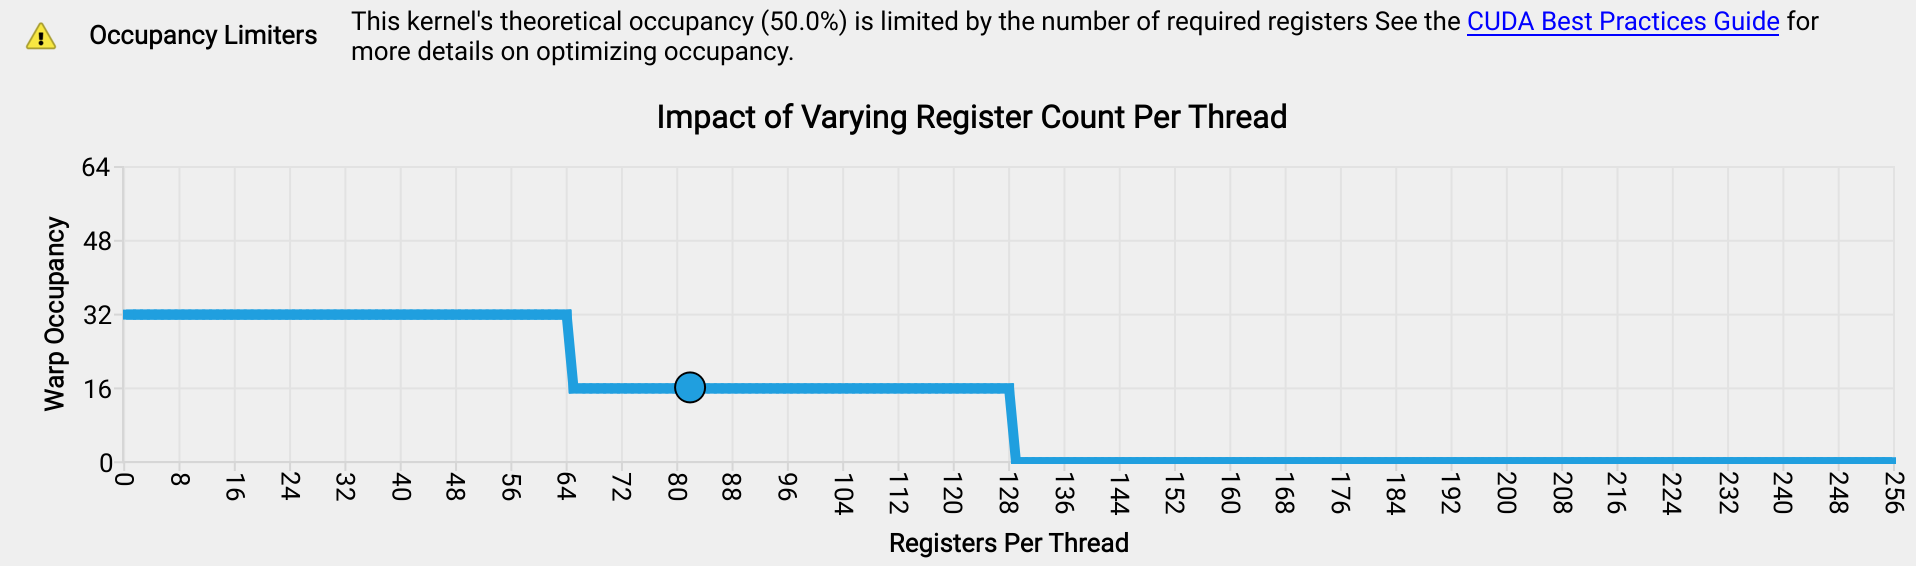

So let's go back to our RMSE kernel and inspect the register usage:

In [25]:
function rmse_kernel(C::AbstractArray{T}, A::AbstractArray{T}, B::AbstractArray{T}) where T
    i = (blockIdx().x-1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x

    # grid-stride loop to process elements on a single thread
    val = zero(T)
    while i <= length(A)
        a = A[i]
        b = B[i]
        val += (a-b)^2

        i += stride
    end

    # initialize shared memory
    thread = threadIdx().x
    threads = blockDim().x
    shared = CuDynamicSharedArray(eltype(C), (threads,))
    shared[thread] = val

    # perform a parallel reduction
    d = 1
    while d < threads
        sync_threads()
        index = 2 * d * (thread-1) + 1
        if index <= threads
            other_val = if index + d <= threads
                shared[index+d]
            else
                zero(eltype(C))
            end
            shared[index] = shared[index] + other_val
        end
        d *= 2
    end

    # load the final value on the first thread
    if thread == 1
        val = shared[thread]
        CUDA.@atomic C[] += val
    end

    return
end

A = CUDA.rand(2048, 2048)
B = CUDA.rand(2048, 2048)
C = similar(A, 1)
kernel = @cuda launch=false rmse_kernel(C, A, B);

In [8]:
CUDA.registers(kernel)

26

In [26]:
CUDA.maxthreads(kernel)

1024

Here, it's actually not necessary to lower the register usage, because we can already launch the maximum number of threads per block that our device allows. However, on lower-end devices (with fewer registers) that may not be the case, so let's still try and reduce the register usage.

One way to reduce register usage, is just to ask the compiler by passing the `maxregs` keyword to `@cuda`:

In [28]:
kernel = @cuda launch=false maxregs=10 rmse_kernel(C, A, B)
CUDA.registers(kernel)

16

Here, the compiler managed to shave off quite some registers. However, this comes at the expense of local memory usage:

In [29]:
CUDA.memory(kernel)

(local = 8, shared = 0, constant = 0)

<div class="alert alert-block alert-warning">
    <strong>Warning</strong>: Local memory is essentially per-thread global memory, which easily degrades performance because of the added memory transactions.
</div>

Generally, a better way to reduce register usage is to look at the generated code and try to simplify it. With GPU kernels written in Julia, there's two specific things to look out for:

- avoid exceptions, which cause branches and hurt generated code quality
- avoid needlessly wide types, e.g., using 32-bit integers instead of Julia's default 64-bit ones

Try to optimize the kernel and improve register usage.

First, let's remove bounds checks where they aren't needed:

In [30]:
function rmse_kernel(C::AbstractArray{T}, A::AbstractArray{T}, B::AbstractArray{T}) where T
    i = (blockIdx().x-1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x

    # grid-stride loop to process elements on a single thread
    val = zero(T)
    @inbounds while i <= length(A)                                  # @inbounds
        a = A[i]
        b = B[i]
        val += (a-b)^2

        i += stride
    end

    # initialize shared memory
    thread = threadIdx().x
    threads = blockDim().x
    shared = @inbounds CuDynamicSharedArray(eltype(C), (threads,))  # @inbounds
    @inbounds shared[thread] = val                                  # @inbounds

    # perform a parallel reduction
    d = 1
    while d < threads
        sync_threads()
        index = 2 * d * (thread-1) + 1
        @inbounds if index <= threads                               # @inbounds
            other_val = if index + d <= threads
                shared[index+d]
            else
                zero(eltype(C))
            end
            shared[index] = shared[index] + other_val
        end
        d *= 2
    end

    # load the final value on the first thread
    @inbounds if thread == 1                                        # @inbounds
        val = shared[thread]
        CUDA.@atomic C[] += val
    end

    return
end

kernel = @cuda launch=false rmse_kernel(C, A, B)
CUDA.registers(kernel)

17

Next, let's use Int32 everywhere: (this generally isn't safe, and should be done with care, but let's demonstrate the effect):

In [31]:
function rmse_kernel(C::AbstractArray{T}, A::AbstractArray{T}, B::AbstractArray{T}) where T
    i = (blockIdx().x-Int32(1)) * blockDim().x + threadIdx().x      # Int32
    stride = gridDim().x * blockDim().x

    # grid-stride loop to process elements on a single thread
    val = zero(T)
    @inbounds while i <= length(A)
        a = A[i]
        b = B[i]
        val += (a-b)^2

        i += stride
    end

    # initialize shared memory
    thread = threadIdx().x
    threads = blockDim().x
    shared = @inbounds CuDynamicSharedArray(eltype(C), (threads,))
    @inbounds shared[thread] = val

    # perform a parallel reduction
    d = Int32(1)                                                    # Int32
    while d < threads
        sync_threads()
        index = Int32(2) * d * (thread-Int32(1)) + Int32(1)         # Int32
        @inbounds if index <= threads
            other_val = if index + d <= threads
                shared[index+d]
            else
                zero(eltype(C))
            end
            shared[index] = shared[index] + other_val
        end
        d *= Int32(2)                                               # Int32
    end

    # load the final value on the first thread
    @inbounds if thread == 1
        val = shared[thread]
        CUDA.@atomic C[] += val
    end

    return
end

kernel = @cuda launch=false rmse_kernel(C, A, B)
CUDA.registers(kernel)

14

We can see that the code looks really clean now:

In [32]:
@device_code_llvm debuginfo=:none @cuda launch=false rmse_kernel(C, A, B);

; PTX CompilerJob of MethodInstance for rmse_kernel(::CuDeviceVector{Float32, 1}, ::CuDeviceMatrix{Float32, 1}, ::CuDeviceMatrix{Float32, 1}) for sm_60
define ptx_kernel void @_Z11rmse_kernel13CuDeviceArrayI7Float32Li1ELi1EES_IS0_Li2ELi1EES_IS0_Li2ELi1EE({ i64, i32 } %state, { i8 addrspace(1)*, i64, [1 x i64], i64 } %0, { i8 addrspace(1)*, i64, [2 x i64], i64 } %1, { i8 addrspace(1)*, i64, [2 x i64], i64 } %2) local_unnamed_addr {
conversion:
  %.fca.0.extract11 = extractvalue { i8 addrspace(1)*, i64, [1 x i64], i64 } %0, 0
  %.fca.3.extract5 = extractvalue { i8 addrspace(1)*, i64, [2 x i64], i64 } %1, 3
  %3 = call i32 @llvm.nvvm.read.ptx.sreg.ctaid.x()
  %4 = call i32 @llvm.nvvm.read.ptx.sreg.ntid.x()
  %5 = mul i32 %3, %4
  %6 = call i32 @llvm.nvvm.read.ptx.sreg.tid.x()
  %7 = add nuw nsw i32 %6, 1
  %8 = add i32 %7, %5
  %9 = call i32 @llvm.nvvm.read.ptx.sreg.nctaid.x()
  %10 = mul i32 %9, %4
  %11 = sext i32 %8 to i64
  %.not23 = icmp slt i64 %.fca.3.extract5, %11
  br i1 %.not23,

## Memory coalescing

AKA: Is CUDA.jl row or column major?
Julia is column major, and CUDA.jl follows those conventions.

With CPU code, the recommendation is that **the leftmost index should be the one changing the quickest** (i.e. in the inner loop). That's because incrementing the leftmost index moves to the next location in memory, benefiting from spatial locality.

With GPUs, spatial locality is important as well, but across threads in a warp. That means **consecutive threads in a warp should be accessing consecutive locations in memory**, i.e., the leftmost index should depend on the thread index.

For example, let's look at a simple `axpy` kernel:

In [68]:
a = rand(Float32)
X = rand(Float32, 512, 512)
Y = rand(Float32, 512, 512);

In [69]:
dX = CuArray(X)
dY = CuArray(Y);

In [70]:
import LinearAlgebra

function axpy!(a, X, Y)
    size(X) == size(Y) || throw(ArgumentError("$X and $Y should have equal size"))

    function kernel(a, X, Y)
        i = blockIdx().x
        j = threadIdx().x

        @inbounds Y[i,j] = a*X[i,j] + Y[i,j]

        return
    end

    @cuda threads=size(X,2) blocks=size(X,1) kernel(a, X, Y)

    return Y
end

axpy!(a, dX, dY)
LinearAlgebra.axpy!(a, X, Y)
Y ≈ Array(dY)

true

In [71]:
@benchmark CUDA.@sync axpy!(a, dX, dY)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  46.063 μs … 106.351 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     46.878 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   47.203 μs ±   1.856 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▄▇██▆▅▃▃▃▂▂                                                 ▂
  ██████████████▇▇▇▇▇▇▆▆▅▄▅▄▁▄▅▁▄▄▄▃▄▅▄▄▁▅▁▅▃▃▃▄▁▄▄▃▄▃▁▄▃▄▆▅▆▆ █
  46.1 μs       Histogram: log(frequency) by time      58.3 μs <

 Memory estimate: 992 bytes, allocs estimate: 21.

This kernel doesn't follow the above guideline. By not using the thread index as the leftmost index, consecutive threads in a warp won't be accessing consecutive locations in memory! Let's fix that:

In [72]:
function axpy!(a, X, Y)
    size(X) == size(Y) || throw(ArgumentError("$X and $Y should have equal size"))

    function kernel(a, X, Y)
        i = threadIdx().x
        j = blockIdx().x

        @inbounds Y[i,j] = a*X[i,j] + Y[i,j]

        return
    end

    @cuda threads=size(X,1) blocks=size(X,2) kernel(a, X, Y)

    return Y
end

@benchmark CUDA.@sync axpy!(a, dX, dY)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  15.683 μs … 67.029 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     16.413 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   16.654 μs ±  1.966 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▂█▅                                                        
  ▃▇███▆▄▃▃▂▂▂▂▂▂▂▁▂▁▁▂▂▂▁▁▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▂▁▂▂▂▂▂▂▁▁▂▂▂▂▂▂ ▂
  15.7 μs         Histogram: frequency by time        27.3 μs <

 Memory estimate: 992 bytes, allocs estimate: 21.

Note that this isn't how we'd implement an operation like this. Instead, we'd use linear indexing for simplicity (retaining the above property) together with a grid-stride loop and use of the launch configuration to optimize GPU usage:

In [73]:
function axpy!(a, X, Y)
    size(X) == size(Y) || throw(ArgumentError("$X and $Y should have equal size"))

    function kernel(a, X, Y)
        i0 = threadIdx().x + (blockIdx().x-1) * blockDim().x

        # grid-stride loop
        for i in i0:blockDim().x*gridDim().x:length(Y)
            @inbounds Y[i] = a*X[i] + Y[i]
        end

        return
    end

    kernel = @cuda launch=false kernel(a, X, Y)
    config = launch_configuration(kernel.fun)
    threads = min(config.threads, length(X))
    blocks = min(config.blocks, cld(length(X), threads))

    kernel(a, X, Y; threads, blocks)

    return Y
end

@benchmark CUDA.@sync axpy!(a, dX, dY)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  17.292 μs … 70.241 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     17.930 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   18.155 μs ±  1.564 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    █▇▂▁                                                       
  ▂█████▆▄▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▂▂▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁▂▂▁▁▂▁▁▁▁▂▁▂▁▁▂▂▂ ▃
  17.3 μs         Histogram: frequency by time        27.9 μs <

 Memory estimate: 1008 bytes, allocs estimate: 22.

The performance is slightly worse, though. This is due to the `StepRange` in the `for` loop doing lots more work (e.g. overflow checks), and as a result generating quite some code:

In [66]:
@device_code_llvm axpy!(a, dX, dY)

; PTX CompilerJob of MethodInstance for (::var"#kernel#24")(::Float32, ::CuDeviceMatrix{Float32, 1}, ::CuDeviceMatrix{Float32, 1}) for sm_60
;  @ In[64]:4 within `kernel`
define ptx_kernel void @_Z6kernel7Float3213CuDeviceArrayIS_Li2ELi1EES0_IS_Li2ELi1EE({ i64, i32 } %state, float %0, { i8 addrspace(1)*, i64, [2 x i64], i64 } %1, { i8 addrspace(1)*, i64, [2 x i64], i64 } %2) local_unnamed_addr {
conversion:
  %.fca.0.extract2 = extractvalue { i8 addrspace(1)*, i64, [2 x i64], i64 } %1, 0
  %.fca.0.extract = extractvalue { i8 addrspace(1)*, i64, [2 x i64], i64 } %2, 0
  %.fca.3.extract = extractvalue { i8 addrspace(1)*, i64, [2 x i64], i64 } %2, 3
;  @ In[64]:5 within `kernel`
; ┌ @ /scratch/snx3000/julia/tbesard/daint-gpu/packages/CUDA/hfp7r/src/device/intrinsics/indexing.jl:92 within `#threadIdx`
; │┌ @ /scratch/snx3000/julia/tbesard/daint-gpu/packages/CUDA/hfp7r/src/device/intrinsics/indexing.jl:46 within `threadIdx_x`
; ││┌ @ /scratch/snx3000/julia/tbesard/daint-gpu/packages/CUDA/hf

Let's avoid this by using a simple `while` loop:

In [74]:
function axpy!(a, X, Y)
    size(X) == size(Y) || throw(ArgumentError("$X and $Y should have equal size"))

    function kernel(a, X, Y)
        i = threadIdx().x + (blockIdx().x-1) * blockDim().x
        
        stride = blockDim().x*gridDim().x
        while i <= length(Y)
            @inbounds Y[i] = a*X[i] + Y[i]
            i += stride
        end

        return
    end

    kernel = @cuda launch=false kernel(a, X, Y)
    config = launch_configuration(kernel.fun)
    threads = min(config.threads, length(X))
    blocks = min(config.blocks, cld(length(X), threads))

    kernel(a, X, Y; threads, blocks)

    return Y
end

@benchmark CUDA.@sync axpy!(a, dX, dY)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  15.204 μs … 69.285 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     15.882 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   16.081 μs ±  1.647 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▂▄▆███▇▅▄▃▂▂▁▁▁                                            ▂
  ▇████████████████▆▆▅▄▅▅▅▅▄▅▄▃▃▁▃▃▃▁▃▁▁▄▁▃▁▁▃▁▁▄▃▁▁▁▁▁▁▁▁▁▁▃ █
  15.2 μs      Histogram: log(frequency) by time      22.2 μs <

 Memory estimate: 1008 bytes, allocs estimate: 22.

In [75]:
@device_code_llvm debuginfo=:none axpy!(a, dX, dY)

; PTX CompilerJob of MethodInstance for (::var"#kernel#29")(::Float32, ::CuDeviceMatrix{Float32, 1}, ::CuDeviceMatrix{Float32, 1}) for sm_60
define ptx_kernel void @_Z6kernel7Float3213CuDeviceArrayIS_Li2ELi1EES0_IS_Li2ELi1EE({ i64, i32 } %state, float %0, { i8 addrspace(1)*, i64, [2 x i64], i64 } %1, { i8 addrspace(1)*, i64, [2 x i64], i64 } %2) local_unnamed_addr {
conversion:
  %.fca.3.extract = extractvalue { i8 addrspace(1)*, i64, [2 x i64], i64 } %2, 3
  %3 = call i32 @llvm.nvvm.read.ptx.sreg.tid.x()
  %4 = add nuw nsw i32 %3, 1
  %5 = call i32 @llvm.nvvm.read.ptx.sreg.ctaid.x()
  %6 = zext i32 %5 to i64
  %7 = call i32 @llvm.nvvm.read.ptx.sreg.ntid.x()
  %8 = zext i32 %7 to i64
  %9 = mul nuw nsw i64 %6, %8
  %10 = zext i32 %4 to i64
  %11 = add nuw nsw i64 %9, %10
  %.not10 = icmp sgt i64 %11, %.fca.3.extract
  br i1 %.not10, label %L109, label %L58.lr.ph

L58.lr.ph:                                        ; preds = %conversion
  %12 = call i32 @llvm.nvvm.read.ptx.sreg.nctaid.x()